#  Differential-Drive Robot in Artificial Gravity
Do all imports:

In [1]:
import sympy as sym
import numpy as np
# This module is part of the python standard library
import time
import scipy
from scipy import signal
# These modules are part of other existing libraries
import matplotlib.pyplot as plt

import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the "latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'C:\\Users\\Omar\\ae353-sp22\\projects\\02_segbot\\ae353_segbot.py'>

# Theory 
## Derive State-Space Model
Define constants used in equations of motion:

In [2]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

In [3]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

Define our symbols:

In [4]:
# symbols and unkown variables associated with our equations of motion
(e_l,
 e_h,
 v,
 w,
 theta,
 p,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, p, tau_R, tau_L', real=True)

Define the components of our equations of motion:

In [5]:
# initializing equations of motion
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + p**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * p - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])

Define our complete equations of motion in matrix form:

In [6]:
part_f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L],[tau_R]])))

# complete equations of motion
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [part_f[0]],
                [part_f[1]],
                [p],
                [part_f[2]]])
f

Matrix([
[                                                                                                                                                                    v*sin(e_h)],
[                                                                                                                                                                             w],
[        -(1200*tau_L + 1200*tau_R + 1404*(p**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                    32*(-1443*p*w*sin(2*theta) - 875*tau_L + 875*tau_R - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                             p],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(p**2 + w**2

Choose equilibrium points:

In [7]:
# defineing equalibrium points of the system
e_le = 0.
e_he = 0.
v_e = 1.
w_e = 0.
theta_e = 0
p_e = 0.
tau_Re = 0.
tau_Le = 0.

Verify equilibrium point, equations of motion should produce zeros:

In [8]:
# Turning our equations of motion into a function and making sure we chose valid equalibrium points
f_num = sym.lambdify([e_l, e_h, v, w, theta, p, tau_R, tau_L], f)
print(f_num(e_le, e_he, v_e, w_e, theta_e, p_e, tau_Re, tau_Le))


[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]]


Linearize about equalibrium points:

In [9]:
# defineing A and B matrices
A_num = sym.lambdify([e_l, e_h, v, w, theta, p, tau_R, tau_L], f.jacobian([e_l, e_h, v, w, theta, p]))
B_num = sym.lambdify([e_l, e_h, v, w, theta, p, tau_R, tau_L], f.jacobian([tau_R, tau_L]))

A = A_num(e_le, e_he, v_e, w_e, theta_e, p_e, tau_Re, tau_Le)
B = B_num(e_le, e_he, v_e, w_e, theta_e, p_e, tau_Re, tau_Le)

# show results
print(A)
print(B)

[[   0.            1.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            1.            0.
     0.        ]
 [   0.            0.            0.            0.         -125.
     0.        ]
 [   0.            0.           -0.           -0.           -0.
    -0.        ]
 [   0.            0.            0.            0.            0.
     1.        ]
 [   0.            0.            0.           -0.          541.66666667
    -0.        ]]
[[  0.           0.        ]
 [  0.           0.        ]
 [ 12.07264957  12.07264957]
 [  1.05014439  -1.05014439]
 [  0.           0.        ]
 [-51.46011396 -51.46011396]]


Verify system is stable:

In [10]:
 # Construct W matrix
n = A.shape[0]
W = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

    
print(W.shape)
print(np.linalg.cond(W))
rank = np.linalg.matrix_rank(W)
print(rank == W.shape[0])

(6, 12)
80626342.75533481
True


## Design Linear State Feedback
Use LQR method to find K matrix:

In [11]:
# show results of A and B
print(f'A = {A}')
print(f'B = {B}')

# Use LQR to derive a minimum cost/effort K matrix
Q = np.eye(6) * 1
print(f'Q = {Q.tolist()}')

R = np.eye(2) * 1
print(f'R = {R.tolist()}')

vals = scipy.linalg.solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @  B.T @ vals
print(f'K = {K.tolist()}')

p = scipy.linalg.eigvals(A-B@K)
print(f'p = {p.tolist()}')

A = [[   0.            1.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            1.            0.
     0.        ]
 [   0.            0.            0.            0.         -125.
     0.        ]
 [   0.            0.           -0.           -0.           -0.
    -0.        ]
 [   0.            0.            0.            0.            0.
     1.        ]
 [   0.            0.            0.           -0.          541.66666667
    -0.        ]]
B = [[  0.           0.        ]
 [  0.           0.        ]
 [ 12.07264957  12.07264957]
 [  1.05014439  -1.05014439]
 [  0.           0.        ]
 [-51.46011396 -51.46011396]]
Q = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
R = [[1.0, 0.0], [0.0, 1.0]]
K = [[0.707106781186545, 1.5821871239780962, -0.7071067811866243, 1.4165583958341204, -10.849466

## Implementation
Create an instance of the simulator (Run this only once):

In [65]:
simulator = ae353_segbot.Simulator(
    display=True,
    width=480,
    height=320,
    bumpy=True,
)

Define the controller class with linear state feedback:

In [13]:
# define our controller class
class Controller:
    def __init__(self, K, e_le, e_he, v_e, w_e, theta_e, p_e, tau_Le, tau_Re):
        self.K = K
        self.e_le = e_le
        self.e_he = e_he
        self.v_e = v_e
        self.w_e = w_e
        self.theta_e = theta_e
        self.p_e = p_e
        self.tau_Le = tau_Le
        self.tau_Re = tau_Re
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        x = np.array([[lateral_error - e_le],
                     [heading_error - e_he],
                     [forward_speed - v_e],
                     [turning_rate - w_e],
                     [pitch_angle - theta_e],
                     [pitch_rate - p_e]])
        u = - self.K @ x

        # implement linear state feedback to our system
        right_wheel_torque = u[0,0]
        left_wheel_torque = u[1,0]
        
        return right_wheel_torque, left_wheel_torque

Initialize our controller object:

In [14]:
controller = Controller(K, e_le, e_he, v_e, w_e, theta_e, p_e, tau_Le, tau_Re)

Reset our simulator with initial conditions of our choosing:

In [15]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity= -0.5,
)

Reset controller:

In [16]:
controller.reset()

Set a view to look at simulator:

In [17]:
# show simulation of robot from the backview
simulator.camera_backview()

Run the simulator:

In [18]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Save a snapshot of the simulation window:

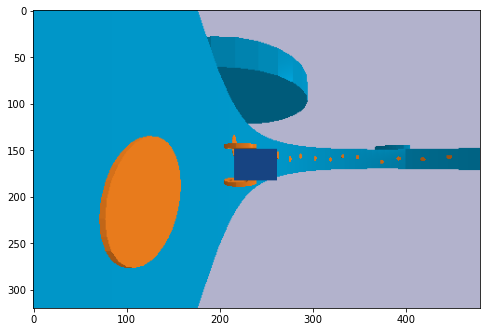

In [19]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot our data:

(0.0, 29.990000000000002)

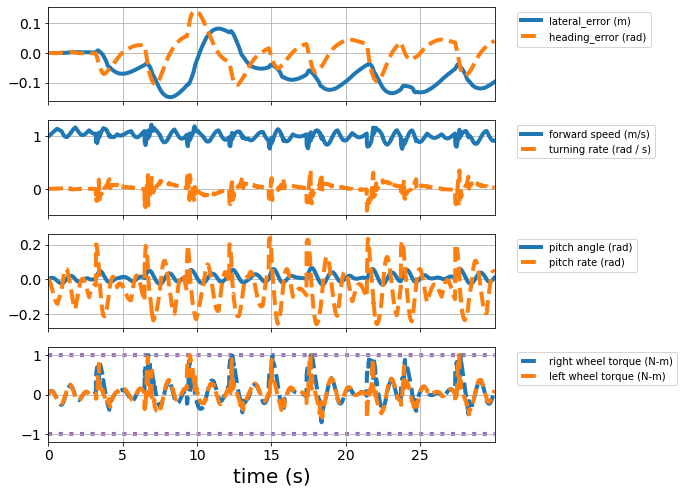

In [20]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pitch.tick_params(labelsize=14)

# Plot torques
# ax_torque.plot(
#     data['t'], data['right_wheel_torque_command'],
#     label='right wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
# ax_torque.plot(
#     data['t'], data['left_wheel_torque_command'],
#     label='left wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
# fig.tight_layout()


Save plot of data:

In [21]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

# Test Limits of Simulation Using Initial Speed
## Max Speed Where Requirements are Met
Reset simulator with a changed initial_speed:

In [22]:
# reset at initial_speed = 1.9 (max speed where requirements are met)
simulator.reset(
    initial_speed=1.9,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity= -0.5,
)

# reset controller
controller.reset()

Define camera orientation of simulation window:

In [23]:
# show simulation of robot from the backview
simulator.camera_backview()

Run the simulation:

In [24]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Plot data from simulation with max intial velocity before requirements are no longer met:

(0.0, 29.990000000000002)

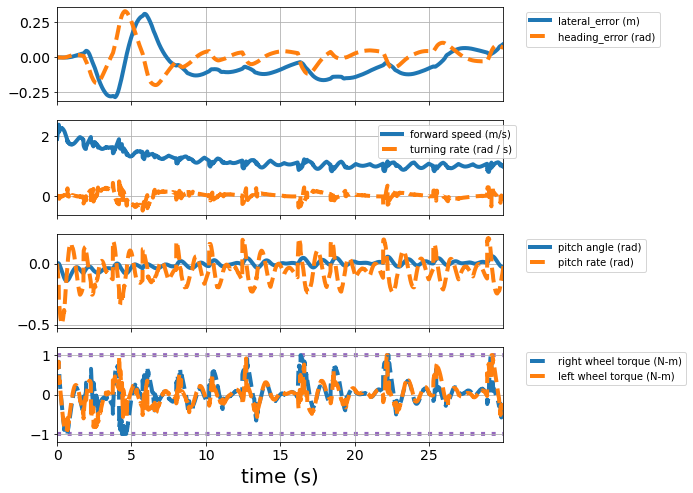

In [25]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pitch.tick_params(labelsize=14)

# Plot torques
# ax_torque.plot(
#     data['t'], data['right_wheel_torque_command'],
#     label='right wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
# ax_torque.plot(
#     data['t'], data['left_wheel_torque_command'],
#     label='left wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])


## Max Speed Before Failure (Robot Falls)
Reset simulator with a changed initial_speed:

In [26]:
# reset at initial_speed = 2.1 (max speed before failure of robot)
simulator.reset(
    initial_speed=2.1,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity= -0.5,
)

# reset controller
controller.reset()

Define camera orientation of simulation window:

In [27]:
# show simulation of robot from the backview
simulator.camera_backview()

Run the simulation:

In [28]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Plot data from simulation with max intial_speed such that the robot does not fail:

(0.0, 29.990000000000002)

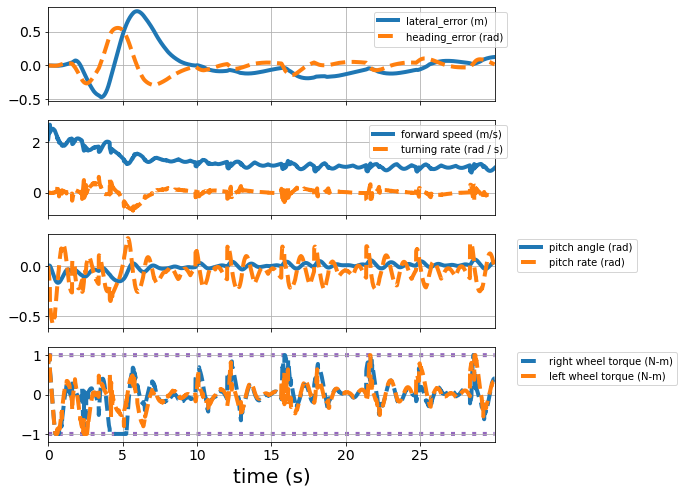

In [29]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pitch.tick_params(labelsize=14)

# Plot torques
# ax_torque.plot(
#     data['t'], data['right_wheel_torque_command'],
#     label='right wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
# ax_torque.plot(
#     data['t'], data['left_wheel_torque_command'],
#     label='left wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

## Speed Where Failure Occurs
Reset simulator with a changed initial_speed:

In [66]:
# reset at initial_speed = 2.2 (failure occurs)
simulator.reset(
    initial_speed=2.2,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity= -0.5,
)

# reset controller
controller.reset()

Define camera orientation of simulation window:

In [67]:
# show simulation of robot from the backview
simulator.camera_backview()

Run the simulation:

In [68]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Plot data from simulation with intial_speed such that the robot fails:

(0.0, 29.990000000000002)

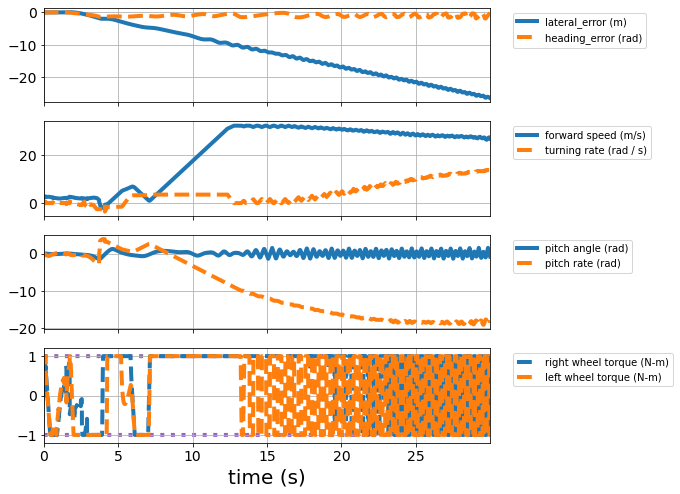

In [62]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_pitch.tick_params(labelsize=14)

# Plot torques
# ax_torque.plot(
#     data['t'], data['right_wheel_torque_command'],
#     label='right wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
# ax_torque.plot(
#     data['t'], data['left_wheel_torque_command'],
#     label='left wheel torque command (N-m)', linewidth=4,
# )

ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=10, bbox_to_anchor=(1.04, 1.))
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])